<a href="https://colab.research.google.com/github/jasreman8/GenAI-Foundational-Projects/blob/main/From_Parameters_To_Reasoning_Tuning_LLM_Outputs_and_Prompt_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

1. Understand the parameters available to control text generation from LLM APIs.

2. Implement key prompt engineering patterns, that is, few-shot, chain-of-thought, rephrase & respond, self-consistency, tree-of-thought & LLM-as-a-judge.





# Setup

Azure provides seamless integration with the OpenAI API to provide access to the GPT-series of models.

In [1]:
!pip install -q openai==1.66.3

In [2]:
from openai import OpenAI

from google.colab import userdata

In [3]:
openai_api_key = userdata.get('my_api_key')

In [4]:
client = OpenAI(
    api_key=openai_api_key
)

In [5]:
model_name = 'gpt-4o-mini'

# Prompt Structure

Prompts presented to the Open AI API for inference have to follow a specific structure with three roles - `system/developer`, `user` and `assistant`.

These roles are:

- `system/developer`: A set of instructions specified for the LLM to follow, as outlined by the application developer. The Open AI API considers the terms `system` and `developer` interchangeable, with `developer` being the preferred term for future use. Going forward Open AI will reserve the `system` keyword for additional instructions Open AI might insert into the prompt for better performance (as of now this is not a rigid rule).
- `user`: A placeholder for users (i.e., end-users of the application) to present their input
- `assistant`: Response from the LLM where the system message is applied to the user input.

LLMs are tuned to understand sets of instructions as defined by these roles. LLM APIs provide a mechanism to encapsulate the *constant* portion of these instructions as the *system prompt*. While it is is optional, when a system prompt (e.g., "Classify the sentiment of the input sentence. Do not answer any other question") is mentioned, it is automatically pasted ahead of all the instructions entered by the user without us needing to explictly append it with every instruction.

System/Developer messages are a great way to restrict the behaviour of the LLM to a specific, controlled set of instructions. Since end-users of the application have no access to the developer message (and can be edited by only the application developer), there is very less chance of the application being hijacked beyond its intended purpose.

The `user` and `assistant` roles enable:
- multi-turn conversations
- showcasing ideal responses expected from the model

A typical prompt structure is presented in the figure below.


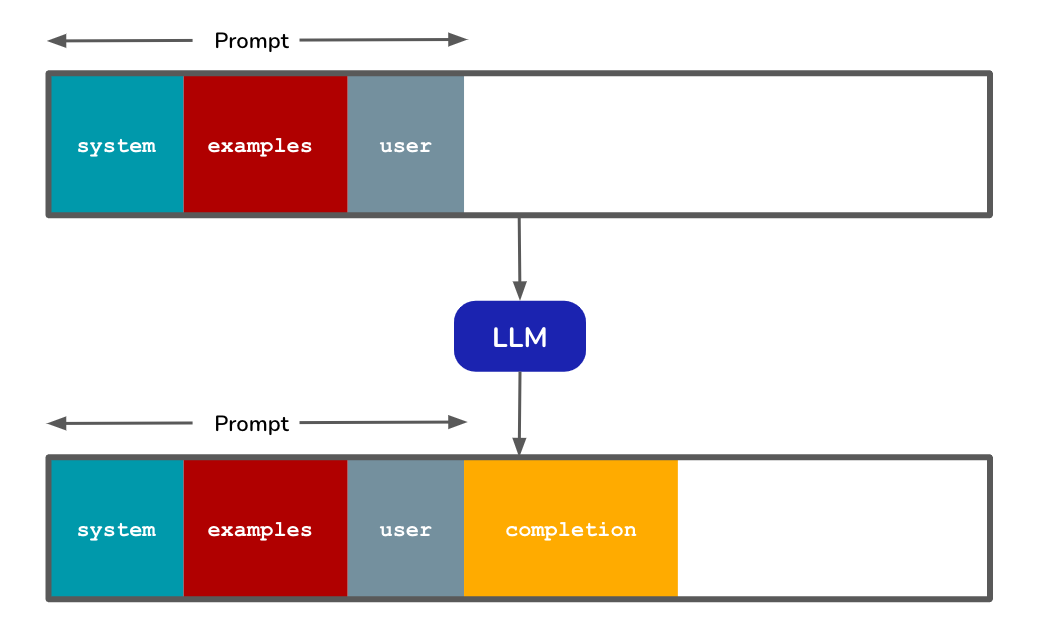

Each example is a pair of `user` and `assistant` messages that illustrates expected output from the LLM.

Let us see these roles in action.

In [6]:
system_message = """
You are an assistant to a hospital administration team working on extracting important information from medical notes made by doctors.
Medical notes will be presented to you in the user input.
Extract relevant information as mentioned below in a json format with the following schema.
- age: integer, age of the patient
- gender: string, can be one of male, female or other
- diagnosis: string, can be one of migraine, diabetes, arthritis and acne
- weight: integer, weight of the patient
- smoking: string, can be one of yes or no
"""

In [7]:
user_input = """
Medical Notes:
---
A 35-year-old male patient, Mr. Nagpal, presented with symptoms
of increased thirst, frequent urination, fatigue, and unexplained
weight loss. Upon evaluation, he was diagnosed with diabetes,
confirmed by elevated blood sugar levels. Mr. Nags' weight
is 80 kgs. He has been prescribed Metformin to be taken twice daily
with meals. It was noted during the consultation that the patient is
a current smoker.
"""

In [8]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "developer", "content": system_message},
        {"role": "user", "content": user_input}
    ]
)

In [9]:
print(response.choices[0].message.content)

```json
{
  "age": 35,
  "gender": "male",
  "diagnosis": "diabetes",
  "weight": 80,
  "smoking": "yes"
}
```


In [10]:
user_input = """
Medical Notes:
---
Patient Name: Ms. Krishnaveni
Age: 45 years
Gender: Female

Chief Complaint:
Ms. Krishnaveni presented with complaints of persistent abdominal pain, bloating, and changes in bowel habits over the past two months.

History of Present Illness:
Ms. Krishnaveni reports experiencing intermittent abdominal pain, predominantly in the lower abdomen, accompanied by bloating and alternating episodes of diarrhea and constipation. She describes the pain as crampy in nature, relieved partially by defecation but worsening after meals. There is no association with specific food items. She denies any rectal bleeding, unintended weight loss, or fever.

Past Medical History:
Ms. Krishnaveni has a history of irritable bowel syndrome (IBS), diagnosed five years ago, managed with dietary modifications and occasional use of over-the-counter antispasmodics.

Medications:
She occasionally takes over-the-counter antispasmodics for symptomatic relief of abdominal discomfort related to IBS.

Family History:
There is no significant family history of gastrointestinal disorders or malignancies.

Social History:
Ms. Krishnaveni is a non-smoker and does not consume alcohol. She works as a teacher in a local school.
"""

In [11]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "developer", "content": system_message},
        {"role": "user", "content": user_input}
    ]
)

In [12]:
print(response.choices[0].message.content)

```json
{
  "age": 45,
  "gender": "female",
  "diagnosis": "acne",
  "weight": 0,
  "smoking": "no"
}
```


# Prompt Parameters

## Maximum tokens

The parameter (`max_tokens`) refers to the maximum number of tokens that can be generated in the chat completion. With this parameter, we can modify the output length like so:

In [13]:
system_message = """
You are an assistant to the marketing team for the gaming company Razer tasked to create advertising content for the company.
You will be presented with product information in the input.
With this information, write a sleek "About this item" description that will be used on its Amazon product page.
Use bullet points to delineate key features mentioned in the description.
"""

In [14]:
user_input = """
Below is the metadata about the Razer Ornata V3 X gaming keyboard:
Brand: Razer
Series: Ornata V3 X
Item model number: RZ03-04470200-R3U1
Hardware Platform: PC
Operating System: Microsoft Windows
Item Weight: 2.97 pounds
Product Dimensions: 17.46 x 5.68 x 1.23 inches
Item Dimensions LxWxH: 17.46 x 5.68 x 1.23 inches
Color: Classic Black
Manufacturer: Razer
Language: English
ASIN: B09X6GJ691
Special Features: Low-Profile Keys, Spill Resistant, Ergonomic Wrist Rest, Chroma RGB Lighting, Silent Membrane Switches, Cable Routing Options
"""

In [15]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "developer", "content": system_message},
        {"role": "user", "content": user_input}
    ],
    max_tokens=1024
)

In [16]:
print(response.choices[0].message.content)

### About this item

Experience the perfect blend of performance and comfort with the Razer Ornata V3 X gaming keyboard, designed to elevate your gaming experience to new heights.

- **Low-Profile Keys:** Enjoy a sleek design paired with a responsive typing experience for quick gaming reactions.
- **Spill Resistant:** Play with confidence; the keyboard is designed to withstand accidental spills, ensuring durability.
- **Ergonomic Wrist Rest:** Stay comfortable during extended gaming sessions with a supportive wrist rest that alleviates strain.
- **Chroma RGB Lighting:** Customize your keyboard with vivid colors and dynamic effects using Razer’s iconic Chroma RGB lighting.
- **Silent Membrane Switches:** Experience quieter keystrokes without sacrificing performance, making it perfect for both gaming and office use.
- **Cable Routing Options:** Keep your setup neat and tidy with versatile cable management options.

Elevate your gameplay with the design and functionality that Razer is kno

## Temperature

In [17]:
system_message = """
You are an assistant to the marketing team for the gaming company Razer tasked to create advertising content for the company.
You will be presented with product information in the input.
With this information, write a sleek "About this item" description that will be used on its Amazon product page.
Use bullet points to delineate key features mentioned in the description.
"""

In [18]:
user_input = """
Below is the metadata about the Razer Ornata V3 X gaming keyboard:
Brand: Razer
Series: Ornata V3 X
Item model number: RZ03-04470200-R3U1
Hardware Platform: PC
Operating System: Microsoft Windows
Item Weight: 2.97 pounds
Product Dimensions: 17.46 x 5.68 x 1.23 inches
Item Dimensions LxWxH: 17.46 x 5.68 x 1.23 inches
Color: Classic Black
Manufacturer: Razer
Language: English
ASIN: B09X6GJ691
Special Features: Low-Profile Keys, Spill Resistant, Ergonomic Wrist Rest, Chroma RGB Lighting, Silent Membrane Switches, Cable Routing Options
"""

In [19]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "developer", "content": system_message},
        {"role": "user", "content": user_input}
    ],
    temperature=0.4,
    max_tokens=256,
    n=2 # number of responses (we are going to have two separate outputs)
)

In [20]:
print(response.choices[0].message.content)

### About this item

- **Low-Profile Keys**: Experience a sleek design with low-profile keys that provide a comfortable and responsive typing experience, perfect for both gaming and daily use.
- **Spill Resistant**: Designed with durability in mind, the Razer Ornata V3 X features a spill-resistant design to protect against accidental spills and ensure longevity.
- **Ergonomic Wrist Rest**: Enjoy extended gaming sessions with an ergonomic wrist rest that provides optimal support and comfort, reducing strain on your wrists.
- **Chroma RGB Lighting**: Customize your setup with vibrant Chroma RGB lighting, allowing you to choose from a spectrum of colors and effects to match your gaming style.
- **Silent Membrane Switches**: Benefit from quiet yet tactile feedback with silent membrane switches, making it perfect for late-night gaming without disturbing others.
- **Cable Routing Options**: Keep your gaming area tidy with built-in cable routing options, allowing you to manage your cables eff

In [21]:
print(response.choices[1].message.content)

### About this item

Elevate your gaming experience with the Razer Ornata V3 X Gaming Keyboard, designed for both performance and comfort. This sleek and stylish keyboard combines innovative features with a classic black finish, making it a perfect addition to any gaming setup.

- **Low-Profile Keys**: Enjoy a comfortable typing experience with responsive low-profile keys that enhance your gameplay.
- **Spill Resistant Design**: Play without worry; the keyboard's spill-resistant construction protects against accidental spills.
- **Ergonomic Wrist Rest**: Stay comfortable during long gaming sessions with the included ergonomic wrist rest that supports your hands.
- **Chroma RGB Lighting**: Customize your keyboard with vibrant Chroma RGB lighting, allowing you to create stunning lighting effects that sync with your games.
- **Silent Membrane Switches**: Experience quiet yet tactile feedback with silent membrane switches, perfect for late-night gaming.
- **Cable Routing Options**: Keep yo

Reducing the temperature reduces variability in generation.

In [22]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "developer", "content": system_message},
        {"role": "user", "content": user_input}
    ],
    temperature=0,
    max_tokens=256,
    n=2
)

In [23]:
print(response.choices[0].message.content)

### About this item

Elevate your gaming experience with the Razer Ornata V3 X gaming keyboard, designed for both performance and comfort. This sleek and stylish keyboard combines innovative features with a classic black finish, making it the perfect addition to your gaming setup.

- **Low-Profile Keys**: Enjoy a comfortable typing experience with keys that are designed for quick response and reduced fatigue during long gaming sessions.
- **Spill Resistant**: Play with confidence knowing that accidental spills won't ruin your keyboard, thanks to its durable spill-resistant design.
- **Ergonomic Wrist Rest**: Stay comfortable during extended gameplay with an ergonomic wrist rest that provides support and reduces strain.
- **Chroma RGB Lighting**: Customize your gaming atmosphere with vibrant Chroma RGB lighting, allowing you to choose from a spectrum of colors and effects.
- **Silent Membrane Switches**: Experience quiet and responsive keystrokes with silent membrane switches, perfect f

In [24]:
print(response.choices[1].message.content)

### About this item

Elevate your gaming experience with the Razer Ornata V3 X gaming keyboard, designed for both performance and comfort. This sleek and stylish keyboard combines innovative features with a classic black finish, making it the perfect addition to your gaming setup.

- **Low-Profile Keys**: Enjoy a comfortable typing experience with keys that are designed for quick response and reduced fatigue during long gaming sessions.
- **Spill Resistant**: Play with confidence knowing that accidental spills won't ruin your keyboard, thanks to its durable spill-resistant design.
- **Ergonomic Wrist Rest**: Stay comfortable during extended gameplay with the included ergonomic wrist rest, providing support and reducing strain.
- **Chroma RGB Lighting**: Customize your gaming atmosphere with vibrant Chroma RGB lighting, allowing you to choose from a spectrum of colors and effects.
- **Silent Membrane Switches**: Experience quiet yet responsive keystrokes, perfect for both gaming and typ

# Structuring Prompts

## Few-shot prompting

While system/developer messages could be used to control the behaviour of LLMs, they become quickly unwieldy when we expect the output to follow a specific format (e.g., JSON). In such situations, few examples go a long way in specifying the behavior of the LLM (i.e., *show, rather than tell*). This technique is referred to as few-shot prompting.

Few shot prompt relies on assembling exemplars that specify the output format from the LLM. These exemplars could represent text-to-label tasks or text-to-text tasks.

Remember, that these examples are only for illustration of format; the LLM is in inference mode and does not adapt its internal representation based on these examples.

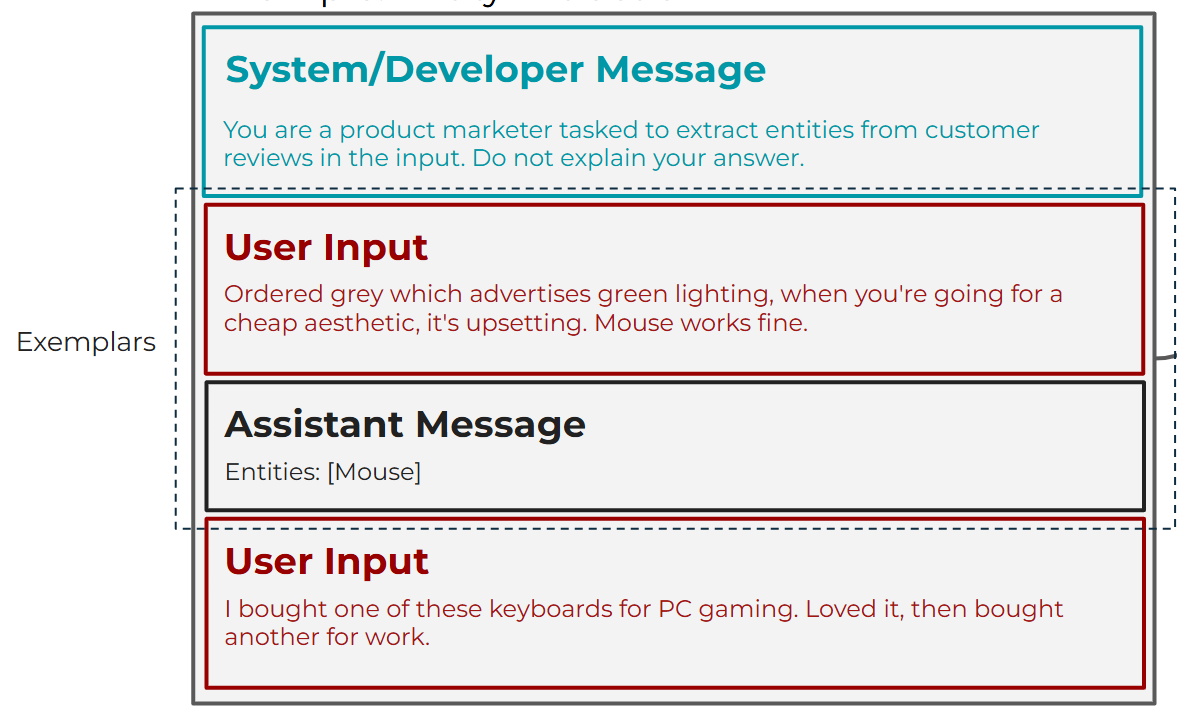

Let us now implement a few-shot prompt in code. While we will task the LLM to execute sentiment analysis, we will force the model to follow a specific output format. Instead of describing the format in a system message, we will show the format in action as a set of two examples of assistant responses.

In [25]:
few_shot_system_message = """
You are a product marketer tasked to classify customer reviews in the input as positive or negative in sentiment.
Do not explain your answer.
Present your output in the following format:
{'sentiment': <'positive' or 'negative'>}
"""

Notice how the system message focuses solely on the task. It mentions that the reviews will be presented in the user input.

In [26]:
user_input_example1 = """
Review:
I couldn't be happier with my experience at your store!
The staff went above and beyond to assist me, providing exceptional customer service.
They were friendly, knowledgeable, and genuinely eager to help.
The product I purchased exceeded my expectations and was exactly what I was looking for.
From start to finish, everything was seamless and enjoyable.
I will definitely be returning and recommending your store to all my friends and family.
Thank you for making my shopping experience so wonderful!
"""

In [27]:
assistant_output_example1 = "{'sentiment': 'positive'}"

Notice how we want the output to follow a specific format, that is, a dictionary-like data structure.

In [28]:
user_input_example2 = """"
Review:
I am extremely disappointed with the service I received at your store!
The staff was rude and unhelpful, showing no regard for my concerns.
Not only did they ignore my requests for assistance, but they also had the audacity to speak to me condescendingly.
It's clear that your company values profit over customer satisfaction.
I will never shop here again and will make sure to spread the word about my awful experience.
You've lost a loyal customer, and I hope others steer clear of your establishment!
"""

In [29]:
assistant_output_example2 = "{'sentiment': 'negative'}"

In [30]:
new_user_input = """
Review:
The layout of the store was well-thought-out, with clear signage and organized aisles that made it easy to navigate.
I appreciated the strategic placement of product categories, which not only facilitated a smooth shopping experience but also made it effortless to find exactly what I was looking for.
The store's cleanliness and neat displays added to the overall appeal, creating an aesthetically pleasing environment.
"""

In [31]:
few_shot_prompt = [
        {"role": "developer", "content": few_shot_system_message},
        {"role": "user", "content": user_input_example1},
        {"role": "assistant", "content": assistant_output_example1},
        {"role": "user", "content": user_input_example2},
        {"role": "assistant", "content": assistant_output_example2},
        {"role": "user", "content": new_user_input}
]

In [32]:
response = client.chat.completions.create(
    model=model_name,
    messages=few_shot_prompt,
    temperature=0
)

In [33]:
print(response.choices[0].message.content)

{'sentiment': 'positive'}


To reiterate, the model does not "learn" from the content of the examples. It simply learns the format of the input and output. To verify this, let us swap labels of the examples.

In [34]:
few_shot_prompt = [
        {"role": "developer", "content": few_shot_system_message},
        {"role": "user", "content": user_input_example1},
        {"role": "assistant", "content": assistant_output_example2},
        {"role": "user", "content": user_input_example2},
        {"role": "assistant", "content": assistant_output_example1},
        {"role": "user", "content": new_user_input}
]

In [35]:
response = client.chat.completions.create(
    model=model_name,
    messages=few_shot_prompt,
    temperature=0
)

In [36]:
print(response.choices[0].message.content)

{'sentiment': 'positive'}


As the above output indicates, the model does not change its answer.

Finally, a simpler variant of few-shot prompting where no examples are provided is called zero-shot prompting. Here is a zero-shot prompt in action.

In [37]:
zero_shot_system_message = """
You are a product marketer tasked to classify customer reviews in the input as positive or negative in sentiment.
Do not explain your answer.
Present your output in the following format:
{'sentiment': <'positive' or 'negative'>}
"""

new_user_input = """
Review:
The layout of the store was well-thought-out, with clear signage and organized aisles that made it easy to navigate.
I appreciated the strategic placement of product categories, which not only facilitated a smooth shopping experience but also made it effortless to find exactly what I was looking for.
The store's cleanliness and neat displays added to the overall appeal, creating an aesthetically pleasing environment.
"""

zero_shot_prompt = [
        {"role": "developer", "content": zero_shot_system_message},
        {"role": "user", "content": new_user_input}
]

response = client.chat.completions.create(
    model=model_name,
    messages=zero_shot_prompt,
    temperature=0
)

print(response.choices[0].message.content)

{'sentiment': 'positive'}


## Chain-of-Thought (CoT) prompting

Chain-of-Thought prompting is a technique used in generative AI tasks to guide the model's response generation by providing a sequence of related prompts or questions. Instead of a single prompt, a CoT consists of multiple interconnected steps that build upon each other to guide the model's thinking process. These steps represent the "thinking" process that we want the model to follow.

The purpose of CoT prompting is to encourage the model to generate more coherent and contextually relevant responses by guiding its thought process in a structured manner. Each step in the chain serves as a stepping stone, providing additional context or constraints for the model to consider while generating the response.

CoT prompts could also be augmented with few-shot examples, so that the prompt guides the reasoning power of the model while examples guide expected output.

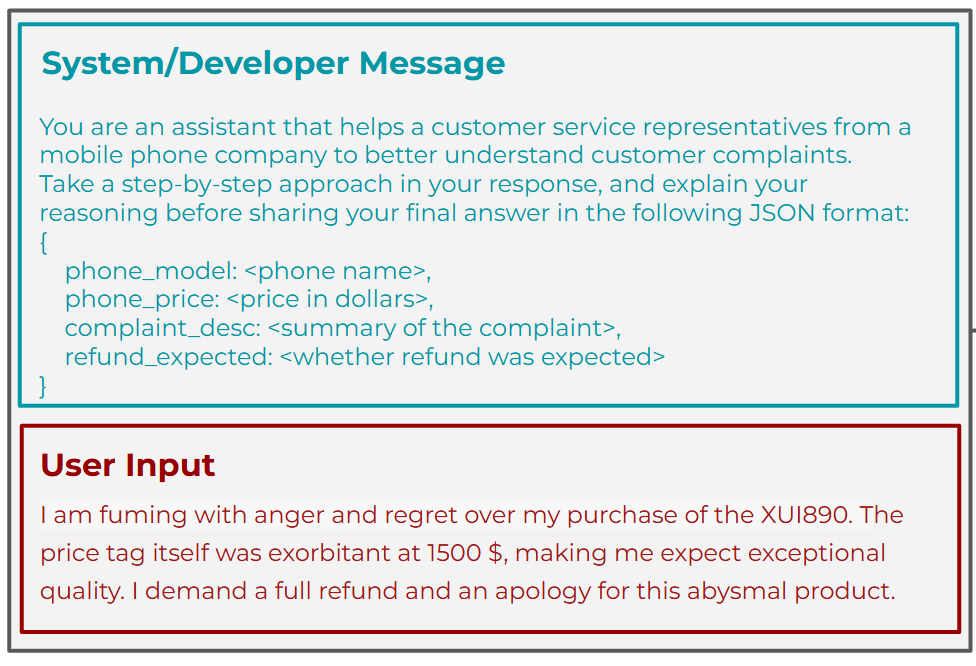

Let us now implement a chain-of-thought prompt for entity extraction. Let us begin by writing a system message that outlines clearly the expected

In [38]:
system_message = """
You are an assistant that helps a customer service representatives from a mobile phone company to better understand customer complaints.
For each complaint, extract the following information and present it only in a JSON format:
1. phone_model: This is the name of the phone - if unknown, just say “UNKNOWN”
2. phone_price: The price in dollars - if unknown, assume it to be 1000 $
3. complaint_desc: A short description/summary of the complaint in less than 20 words
4. additional_charges: How much in dollars did the customer spend to fix the problem? - this should be an integer
5. refund_expected: TRUE or FALSE - check if the customer explicitly mentioned the word “refund” to tag as TRUE. If unknown, assume that the customer is not expecting a refund

Take a step-by-step approach in your response, before sharing your final answer in the following JSON format:
{
    phone_model: <phone name>,
    phone_price: <price in dollars>,
    complaint_desc: <summary of the complaint>,
    additional_charges: <charges incurred in repair>,
    refund_expected: <whether refund was expected>
}

Explain your reasoning before presenting the final answer.
"""

In [39]:
customer_complaint = """
I am fuming with anger and regret over my purchase of the XUI890.
First, the price tag itself was exorbitant at 1500 $, making me expect exceptional quality.
Instead, it turned out to be a colossal disappointment.
The additional charges to fix its constant glitches and defects drained my wallet even more.
I spend 275 $ to get a new battery.
The final straw was when the phone's camera malfunctioned, and the repair cost was astronomical.
I demand a full refund and an apology for this abysmal product.
Returning it would be a relief, as this phone has become nothing but a money pit. Beware, fellow buyers!
"""

In [40]:
cot_prompt = [
        {"role": "developer", "content": system_message},
        {"role": "user", "content": customer_complaint}
]

In [41]:
response = client.chat.completions.create(
    model=model_name,
    messages=cot_prompt,
    temperature=0
)

In [42]:
print(response.choices[0].message.content)

Let's break down the complaint step by step:

1. **phone_model**: The customer explicitly mentions the phone model as "XUI890".
2. **phone_price**: The customer states the price as 1500 $, but since we need to assume a standard price of 1000 $ for unknown cases, we will use 1000 $ here.
3. **complaint_desc**: The customer expresses disappointment with the phone, which can be summarized as "Phone has constant glitches and defects."
4. **additional_charges**: The customer mentions spending 275 $ to fix the battery, which is the only charge specified.
5. **refund_expected**: The customer explicitly states "I demand a full refund," which indicates that they are expecting a refund.

Now, I will compile this information into the required JSON format:

```json
{
    "phone_model": "XUI890",
    "phone_price": 1000,
    "complaint_desc": "Phone has constant glitches and defects.",
    "additional_charges": 275,
    "refund_expected": true
}
```


## Prompt Chaining

In [43]:
customer_complaint = """
I am fuming with anger and regret over my purchase of the XUI890.
First, the price tag itself was exorbitant at 1500 $, making me expect exceptional quality.
Instead, it turned out to be a colossal disappointment.
The additional charges to fix its constant glitches and defects drained my wallet even more.
I spend 275 $ to get a new battery.
The final straw was when the phone's camera malfunctioned, and the repair cost was astronomical.
I demand a full refund and an apology for this abysmal product.
Returning it would be a relief, as this phone has become nothing but a money pit. Beware, fellow buyers!
"""

In [44]:
system_message1 = """
You are an assistant that helps a customer service representatives from a mobile phone company to better understand customer feedback.
Analyze the customer feedback presented in the input and extract key sentiments and themes.
For each piece of feedback:
1. Identify the main sentiment (positive, negative, neutral)
2. Extract key themes or topics mentioned
3. Note any specific features or products mentioned
"""

In [45]:
first_stage_prompt = [
    {"role": "developer", "content": system_message1},
    {"role": "user", "content": customer_complaint}
]

In [46]:
response = client.chat.completions.create(
    model=model_name,
    messages=first_stage_prompt,
    temperature=0
)

In [47]:
first_stage_output = response.choices[0].message.content

In [48]:
print(first_stage_output)

1. **Main Sentiment**: Negative
2. **Key Themes or Topics Mentioned**: 
   - Disappointment with product quality
   - High price expectations vs. actual performance
   - Additional repair costs and financial burden
   - Request for refund and apology
   - Warning to other potential buyers
3. **Specific Features or Products Mentioned**: 
   - XUI890 (mobile phone)
   - Camera malfunction
   - Battery replacement cost ($275)


In [49]:
system_message2 = """
You are an assistant that helps a customer service representatives from a mobile phone company to better understand customer complaints.
Based on the structured feedback analysis presented in the input, generate actionable insights and recommendations.
For each theme identified:
1. Summarize the overall sentiment
2. List specific issues or strengths mentioned
3. Provide concrete recommendations for improvement
4. Prioritize actions based on impact and effort
"""

In [50]:
second_stage_prompt = [
    {"role": "developer", "content": system_message2},
    {"role": "user", "content": first_stage_output}
]

In [51]:
response = client.chat.completions.create(
    model=model_name,
    messages=second_stage_prompt,
    temperature=0
)

In [52]:
final_output = response.choices[0].message.content

In [53]:
print(final_output)

### Actionable Insights and Recommendations

#### 1. **Product Quality**
   - **Overall Sentiment**: Negative
   - **Specific Issues**: Customers express disappointment with the quality of the XUI890, particularly regarding the camera malfunction.
   - **Recommendations**:
     - **Immediate Action**: Conduct a thorough quality assessment of the XUI890, focusing on the camera and other frequently reported issues.
     - **Long-term Action**: Implement a more rigorous quality control process before product launches to ensure reliability.
   - **Priority**: High impact, moderate effort.

#### 2. **Price Expectations vs. Performance**
   - **Overall Sentiment**: Negative
   - **Specific Issues**: Customers feel that the price of the XUI890 does not match its performance, leading to dissatisfaction.
   - **Recommendations**:
     - **Immediate Action**: Review pricing strategy and consider adjusting the price or offering promotions to align with customer expectations.
     - **Long-term Ac

## Self-consistency

In self-consistency, we generate multiple answers to the same question and pick the answer that is repeated the most across these occurrences. This is particularly valuable for factual questions.

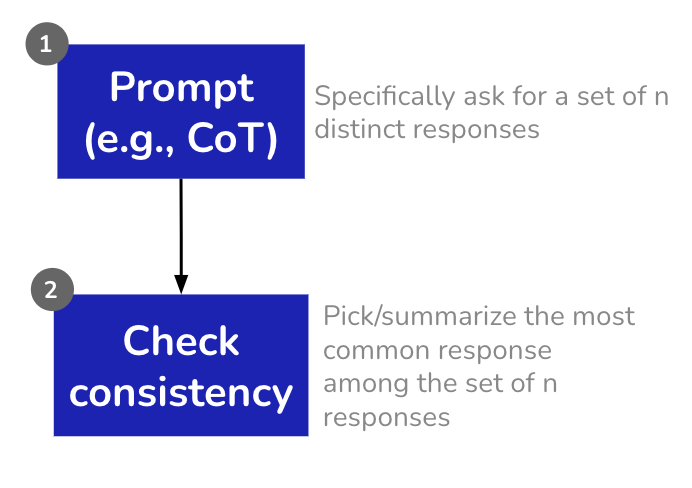

In [54]:
generation_system_message = """
You are a helpful assistant tasked to answer queries on financial information.
The context needed to answer these queries is presented below:

---
Context:
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
---

You will be presented a question in the input.
Using the context above generate 4 distinct answers to the question.
Arrange your answers in numbered bullet points.
"""

In [55]:
user_message_template = """
Question:
{question}.
"""

In [56]:
factual_question = "What was the increase in annual revenue in 2022 compared to 2021?"

In [57]:
answers_prompt = [
    {'role': 'developer', 'content': generation_system_message},
     {'role': 'user', 'content': user_message_template.format(
         question=factual_question
         )
     }
]

In [58]:
response = client.chat.completions.create(
    model=model_name,
    messages=answers_prompt,
    temperature=0
)

In [59]:
factual_answers = response.choices[0].message.content

In [60]:
print(factual_answers)

1. The increase in annual revenue in 2022 compared to 2021 was $27.64 billion.

2. In 2022, the company experienced a revenue growth of $27.64 billion compared to the previous year.

3. The total revenue for 2022 rose by $27.64 billion when compared to the revenue of 2021.

4. Compared to 2021, the annual revenue in 2022 saw an increase of $27.64 billion.


In [61]:
consistency_system_message = """
You are a helpful assistant tasked to answer queries on financial information.
You will be presented a question and 3 AI generated answers to the question in the user input.
Observe the answers mentioned in the input and choose the answer that occurs most.
Present only the most frequent solution in the following format.
Final Answer:
"""

In [62]:
consistency_user_message = """
Question:
{question}.
Answers:
{answers}.
"""

In [63]:
consistency_prompt = [
    {'role': 'developer', 'content': consistency_system_message},
     {'role': 'user', 'content': consistency_user_message.format(
         question=factual_question,
         answers=factual_answers
         )
     }
]

In [64]:
response = client.chat.completions.create(
    model=model_name,
    messages=consistency_prompt,
    temperature=0
)

In [65]:
print(response.choices[0].message.content)

Final Answer: The increase in annual revenue in 2022 compared to 2021 was $27.64 billion.


## Rephrase & Respond

In the Rephrase & Respond method of prompt engineering, we ask the LLM to rephrase the original user question to a format that will enable it to answer better.

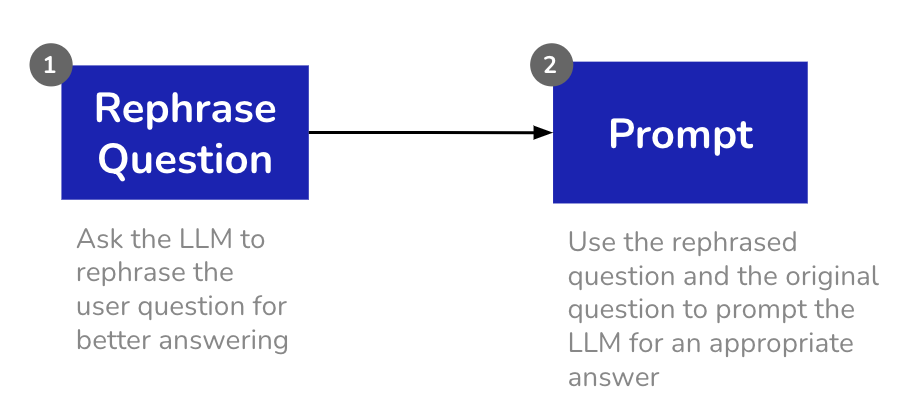

In [66]:
rephrase_system_message = """
You are a helpful assistant tasked to answer queries on financial information.

The context required for you to answer the queries is presented below:

---
Context:
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
---

You will be presented with a question in the input.
Using the context presented above, rephrase and expand the question to help you do better answering.
Maintain all the information in the original question.
Please note that you only have to rephrase the question, do not mention the context or answer the question at this point.
The context is only presented for your reference.
"""

An extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [67]:
user_message = """
Question:
What was the increase in annual revenue in 2022 compared to 2021?
"""

In [68]:
rephrase_prompt = [
    {'role': 'developer', 'content': rephrase_system_message},
    {'role': 'user', 'content': user_message}
]

In [69]:
response = client.chat.completions.create(
    model=model_name,
    messages=rephrase_prompt,
    temperature=0
)

In [70]:
rephrased_factual_question = response.choices[0].message.content

In [71]:
print(rephrased_factual_question)

How much did the annual revenue increase in 2022 when compared to the revenue figures from 2021?


In [72]:
respond_system_message = """
You are a helpful assistant tasked to answer queries on financial information.

The context required for you to answer the queries is presented below:

---
Context:
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
---

You will be presented with a question and a rephrased variant in the input.
Using the context presented above, use your answer for the rephrased question presented above to answer the original question..
Present your final answer in the following format.
Final Answer: <your-final-answer>
"""

In [73]:
user_message = """
Original Question:
What was the increase in annual revenue in 2022 compared to 2021?

Rephrased Question:
What was the difference in total revenues between 2022 and 2021, and how much did it increase in 2022 compared to the previous year?
"""

In [74]:
response_prompt = [
    {'role': 'developer', 'content': respond_system_message},
    {'role': 'user', 'content': user_message}
]

In [75]:
response = client.chat.completions.create(
    model=model_name,
    messages=response_prompt,
    temperature=0
)

In [76]:
print(response.choices[0].message.content)

Final Answer: The increase in total revenues in 2022 compared to 2021 was $27.64 billion.


## LLM-as-a-Judge

In this method, we use another LLM to rate the performance of the LLM used in the original task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

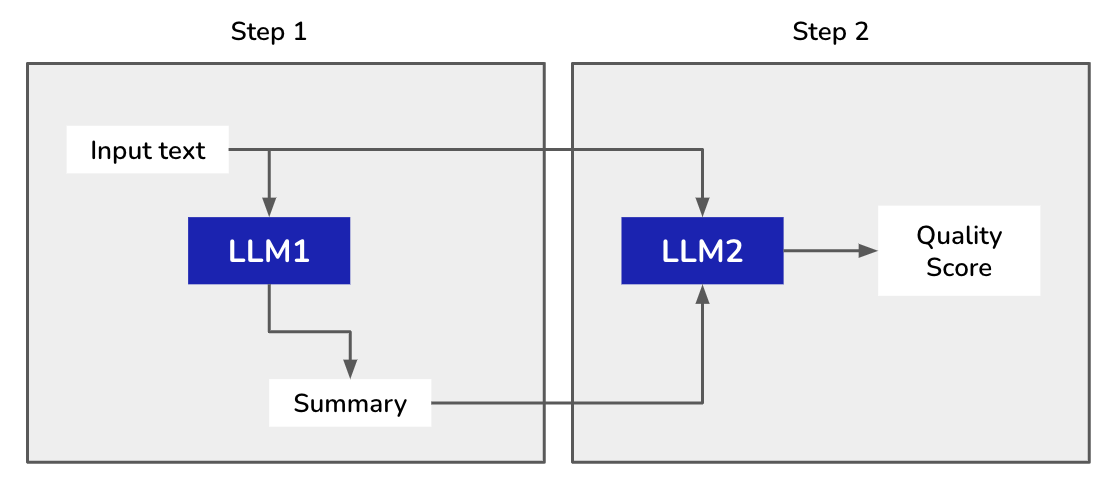

In [77]:
example_dialogue = """
Dialogue:
#Person1#: Excuse me, could you tell me where physics 403 is? Has it been moved?
#Person2#: OK. Let me check on the computer. Err I'm sorry, but it says here that the class was cancelled. You should have got a notice letter about this.
#Person1#: What? I never got it.
#Person2#: Are you sure? It says on the computer that the letter was sent out to the students a week ago.
#Person1#: Really? I should have got it by now. I wonder if I threw it away with all the junk mail by mistake.
#Person2#: Well, it does happen. Err let me check something. What's your name?
#Person1#: Woodhouse Laura Woodhouse.
#Person2#: OK, Woodhouse. Let me see. Ah, it says here we sent it to your apartment on the Center Street.
#Person1#: Oh, that's my old apartment. I moved out of there a little while ago.
#Person2#: Well, I suppose you haven't changed your mailing address at the administration office.
#Person1#: Yeah, I should have changed it in time.
"""

In [78]:
example_summary = """
Summary:
Laura Woodhouse finds out physics is canceled but she never received the mail. #Person2# finds her mailing address is her old apartment. Laura thinks she should have changed it in time.
"""

In [79]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Faithfulness – The factual accuracy and verifiability of the information presented in the summary.
Every piece of information mentioned in the summary should be directly verifiable, supported, or reasonably inferred from the dialogue.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
5. Present your evaluation in the following JSON format:
{
    'step_by_step_explanation': <step-by-step explanation as detailed in steps 1, 2, 3 above>,
    'score': <score>
}
"""

In [80]:
rater_model = 'gpt-4o'

Notice how the rubric is clearly defined. Also the metric used to judge the output is clearly delineated. This prompt can be readily adapted to create multiple raters,e ach focusing on one metric.

In [81]:
rater_user_message = f"""
###Dialogue
{example_dialogue}

###Summary
{example_summary}
"""

In [82]:
rater_prompt = [
    {'role': 'developer', 'content': rater_system_message},
    {'role': 'user', 'content': rater_user_message}
]

In [83]:
response = client.chat.completions.create(
    model=rater_model,
    messages=rater_prompt
)

In [84]:
print(response.choices[0].message.content)

{
    'step_by_step_explanation': "1. Identify all key information in the summary, including the cancellation of the class, the issue with the mailing address, and Laura's realization about changing the address. 2. Verify each piece of information with the dialogue. The dialogue states that the physics class is canceled, and Laura did not receive the notice, which aligns with the summary's statement that 'Laura Woodhouse finds out physics is canceled but she never received the mail.' 3. Check if the mailing address issue is mentioned and verify it against the dialogue. The dialogue confirms the mailing address issue, noting it was sent to Laura's old apartment, consistent with the summary's information. 4. See if the summary mentions Laura's realization that she should have updated her address in time. This is supported by the dialogue where Laura acknowledges she should have changed her address. 5. Since every piece of information in the summary is directly verifiable from the dialogu